In [63]:
import numpy as np
import cv2
import os
import math
from matplotlib import pyplot as plt

#Lectura del la imágen .tif
img = cv2.imread('img/rm_149_004.tif',0)

#Aplicación de Threshold adaptativo
mean = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,15)
gaussian = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,15)

#Para invertir colores
#gaussian = 255 - gaussian

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3));
kernel2 = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3));

#Transformaciones morfológicas

dilation = cv2.dilate(mean,kernel2,iterations = 1)
eroding = cv2.erode(dilation,kernel2,iterations = 2)
dilation = cv2.dilate(eroding,kernel2,iterations = 1)

#Se guardan los imagenes en cada paso
cv2.imwrite('tests/1_UmbralMean.png',gaussian)
cv2.imwrite('tests/2_UmbralGauss.png',gaussian)
cv2.imwrite('tests/3_Erode.png',eroding)
cv2.imwrite('tests/4_Dilate.png',dilation)



True

101.50125628140704
10.07478318781139
2388
42


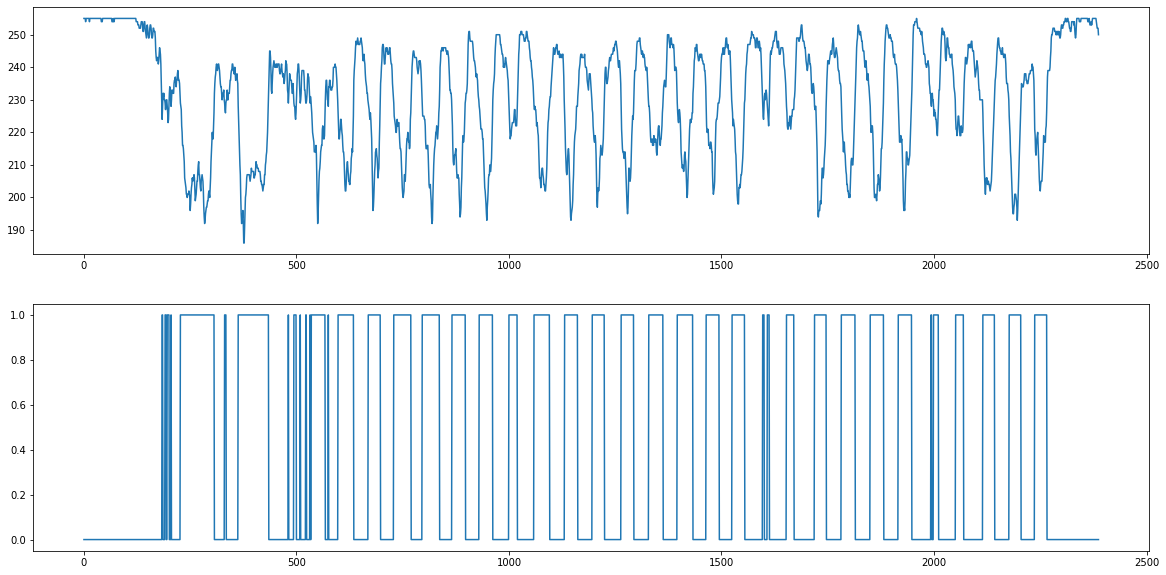

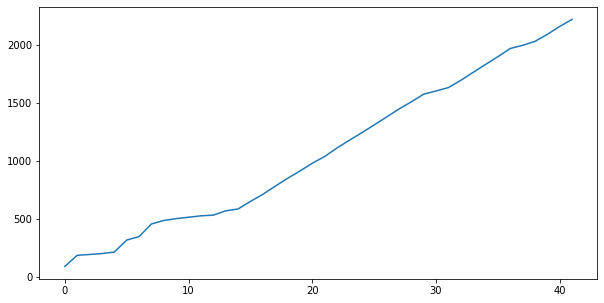

In [82]:
#Se obtiene el valor promedio de cada fila de pixeles de la imagen
reduced = cv2.reduce(dilation, 1, cv2.REDUCE_AVG)

#Se establece un límite para determinar si hay texto o no
limit = np.sqrt(np.mean(reduced**2))
print(np.mean(reduced**2))
print(limit)
limit = 230 #227

#Algoritmo para determinar los límites de cada linea del texto

#1.Creación de vector que indica la presencia o no de texto
cnt = 0
vector = np.zeros(len(reduced))
for avg in reduced:
    if avg < limit:
        vector[cnt] = 1
    else:
        vector[cnt] = 0
    cnt=cnt+1
print(cnt)
#2.Conteo de líneas en el texto
lines = 0
last = 0
for i in range(len(vector)):
    if last == 0:
        if vector[i]==1:
            lines = lines +1
    last = vector[i]
print(lines)
#Creación de vector donde se guardan las filas de 
#pixeles que dividen cada linea de texto
start = 0
divs = np.zeros(lines)
last = 1
line = 0
for i in range(len(vector)):
    if last == 1:
        if vector[i]==0:
            start = i
    elif last == 0:
        if vector[i]==1:
            divs[line] = int((start+i)//2)
            line = line+1
    last = vector[i]

#Figuras de comprobación
plt.figure(1,figsize=(20, 10))

plt.subplot(211)
plt.plot(reduced)
plt.subplot(212)
plt.plot(vector)

plt.figure(2,figsize=(10, 5))
plt.plot(divs)

101.50125628140704
10.07478318781139
2788
34


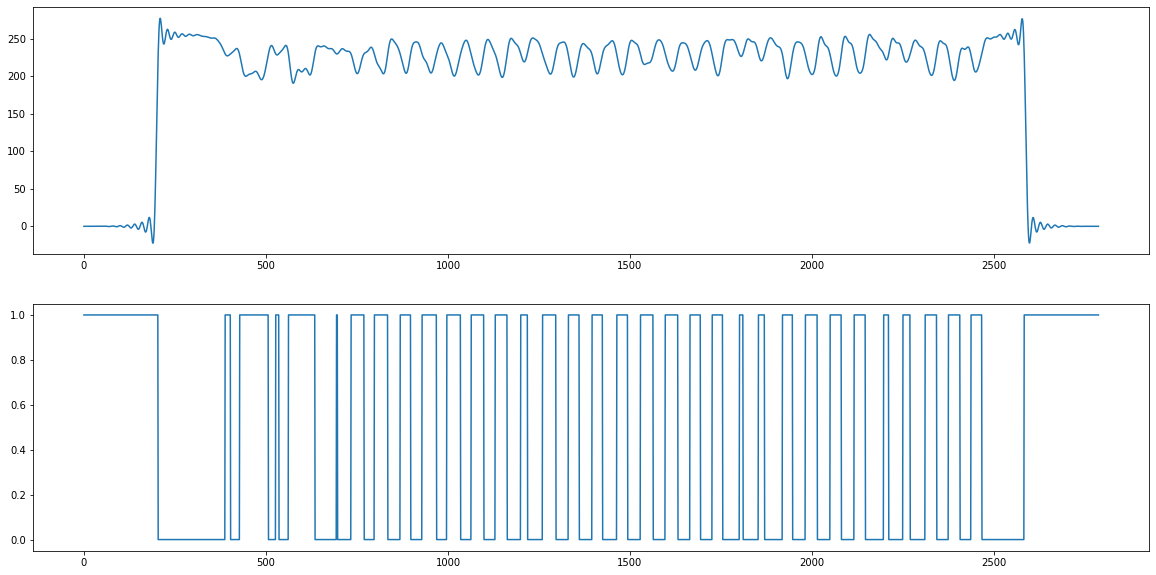

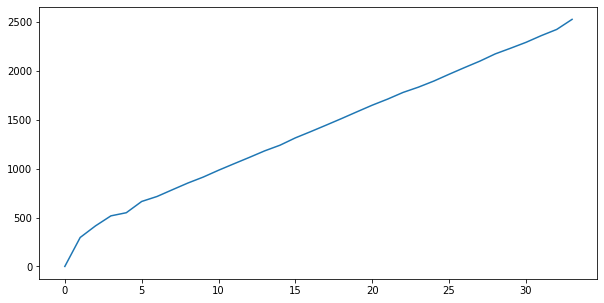

In [69]:
reduced1D=np.ndarray.flatten(reduced)

#Filtro pasa bajos
#https://plot.ly/python/v3/fft-filters/
fc = 0.05
b = 0.01
N = int(np.ceil((4 / b)))
if not N % 2: N += 1
n = np.arange(N)
#
sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
sinc_func = sinc_func * window
sinc_func = sinc_func / np.sum(sinc_func)
#
s = list(reduced1D)
filtered = np.convolve(s, sinc_func)

#Se establece un límite para determinar si hay texto o no
limit = np.sqrt(np.mean(reduced**2))
print(np.mean(reduced**2))
print(limit)
limit = 230 #227

#Algoritmo para determinar los límites de cada linea del texto

#1.Creación de vector que indica la presencia o no de texto
cnt = 0
vectorF = np.zeros(len(filtered))
for avg in filtered:
    if avg < limit:
        vectorF[cnt] = 1
    else:
        vectorF[cnt] = 0
    cnt=cnt+1
print(cnt)
#2.Conteo de líneas en el texto
linesF = 0
last = 0
for i in range(len(vectorF)):
    if last == 0:
        if vectorF[i]==1:
            linesF = linesF +1
    last = vectorF[i]
print(linesF)
#Creación de vector donde se guardan las filas de 
#pixeles que dividen cada linea de texto
start = 0
divsF = np.zeros(linesF)
last = 0
line = 0
for i in range(len(vectorF)):
    if last == 1:
        if vectorF[i]==0:
            start = i
    elif last == 0:
        if vectorF[i]==1:
            divsF[line] = int((start+i)//2)
            line = line+1
    last = vectorF[i]

#Figuras de comprobación
plt.figure(1,figsize=(20, 10))

plt.subplot(211)
plt.plot(filtered)
plt.subplot(212)
plt.plot(vectorF)

plt.figure(2,figsize=(10, 5))
plt.plot(divsF)

In [86]:
#Algoritmo para extraer imagenes de cada una de la filas

#Se establece un márgen para evitar letras cortadas(Ejemplo: Titulo)
margin = 15


if not os.path.exists('tests/lines/'):
    os.mkdir('tests/lines/')

#Se itera sobre todas las lineas
print('Segmented into %d lines'%(lines-1))
for c in range(lines-1):
    #Se extrae la matriz de pixeles de la linea 
    cropped = dilation[int(divs[c])-margin:int(divs[c+1])+margin, 0:1577]
    #Se guarda la linea en archivo .png
    cv2.imwrite('tests/lines/%d.png'%(c-1),cropped)


Segmented into 41 lines


In [87]:
#Algoritmo para segmentación
#https://github.com/githubharald/WordSegmentation.git

def wordSegmentation(img, kernelSize=25, sigma=11, theta=7, minArea=0):
    """Scale space technique for word segmentation proposed by R. Manmatha: http://ciir.cs.umass.edu/pubfiles/mm-27.pdf

    Args:
        img: grayscale uint8 image of the text-line to be segmented.
        kernelSize: size of filter kernel, must be an odd integer.
        sigma: standard deviation of Gaussian function used for filter kernel.
        theta: approximated width/height ratio of words, filter function is distorted by this factor.
        minArea: ignore word candidates smaller than specified area.

    Returns:
        List of tuples. Each tuple contains the bounding box and the image of the segmented word.
    """

    # apply filter kernel
    kernel = createKernel(kernelSize, sigma, theta)
    imgFiltered = cv2.filter2D(img, -1, kernel, borderType=cv2.BORDER_REPLICATE).astype(np.uint8)
    (_, imgThres) = cv2.threshold(imgFiltered, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    imgThres = 255 - imgThres

    # find connected components. OpenCV: return type differs between OpenCV2 and 3
    if cv2.__version__.startswith('3.'):
        (_, components, _) = cv2.findContours(imgThres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        (components, _) = cv2.findContours(imgThres, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # append components to result
    res = []
    for c in components:
        # skip small word candidates
        if cv2.contourArea(c) < minArea:
            continue
        # append bounding box and image of word to result list
        currBox = cv2.boundingRect(c) # returns (x, y, w, h)
        (x, y, w, h) = currBox
        currImg = img[y:y+h, x:x+w]
        res.append((currBox, currImg))

    # return list of words, sorted by x-coordinate
    return sorted(res, key=lambda entry:entry[0][0])


def createKernel(kernelSize, sigma, theta):
    """create anisotropic filter kernel according to given parameters"""
    assert kernelSize % 2 # must be odd size
    halfSize = kernelSize // 2

    kernel = np.zeros([kernelSize, kernelSize])
    sigmaX = sigma
    sigmaY = sigma * theta

    for i in range(kernelSize):
        for j in range(kernelSize):
            x = i - halfSize
            y = j - halfSize

            expTerm = np.exp(-x**2 / (2 * sigmaX) - y**2 / (2 * sigmaY))
            xTerm = (x**2 - sigmaX**2) / (2 * math.pi * sigmaX**5 * sigmaY)
            yTerm = (y**2 - sigmaY**2) / (2 * math.pi * sigmaY**5 * sigmaX)

            kernel[i, j] = (xTerm + yTerm) * expTerm

    kernel = kernel / np.sum(kernel)
    return kernel



for k in range(lines-1):
    if not os.path.exists('tests/line_%s/'%k):
        os.mkdir('tests/line_%s/'%k)
    img = cv2.imread('tests/lines/%d.png'%k,0)
    res = wordSegmentation(img, kernelSize=11, sigma=10, theta=7, minArea=600)
    # iterate over all segmented words
    print('Line %s segmented into %d words'%(k,len(res)))
    for (j, w) in enumerate(res):
        (wordBox, wordImg) = w
        (x, y, w, h) = wordBox
        cv2.imwrite('tests/line_%s/%d.png'%(k,j), wordImg) # save word
        cv2.rectangle(img,(x,y),(x+w,y+h),0,1) # draw bounding box in summary image
    
    if not os.path.exists('tests/lines_segmented/'):
        os.mkdir('tests/lines_segmented/')
    # output summary image with bounding boxes around words
    cv2.imwrite('tests/lines_segmented/%d.png'%k, img)

Line 0 segmented into 3 words
Line 1 segmented into 3 words
Line 2 segmented into 4 words
Line 3 segmented into 24 words
Line 4 segmented into 4 words
Line 5 segmented into 31 words
Line 6 segmented into 5 words
Line 7 segmented into 3 words
Line 8 segmented into 5 words
Line 9 segmented into 5 words
Line 10 segmented into 6 words
Line 11 segmented into 11 words
Line 12 segmented into 6 words
Line 13 segmented into 12 words
Line 14 segmented into 12 words
Line 15 segmented into 11 words
Line 16 segmented into 10 words
Line 17 segmented into 11 words
Line 18 segmented into 11 words
Line 19 segmented into 5 words
Line 20 segmented into 14 words
Line 21 segmented into 9 words
Line 22 segmented into 9 words
Line 23 segmented into 12 words
Line 24 segmented into 12 words
Line 25 segmented into 12 words
Line 26 segmented into 12 words
Line 27 segmented into 8 words
Line 28 segmented into 6 words
Line 29 segmented into 5 words
Line 30 segmented into 6 words
Line 31 segmented into 15 words
Lin